In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load HumanNet Raw Data
#### Source:  https://www.inetbio.org/humannet/networks/HumanNet-FN.tsv & https://www.inetbio.org/humannet/networks/HumanNet-XC.tsv

Downloaded: November 16, 2021  
Last updated: 2021, published Jan 2022   
  
**Note**: There are multiple networks available, we have chosen to use the composite Functional Network(FN) which contains data from co-expression (CX), pathway databases (DB), domain profile associations (DP), genetic interactions (GI), gene neighborhood (GN), phylogenetic profile associations (PG) and protein-protein interaction networks (PI). Data is also extracted from the XC network which contains all of FN with additional co-citation links

<u>HumanNet Citations</u>:  
**V1**: Insuk Lee, U. Martin Blom, Peggy I. Wang, Jung Eun Shin, and Edward M. Marcotte
Genome Research 21(7):1109-21 (2011)  
**V2**: Hwang S, Kim CY, Yang S, Kim E, Hart T, Marcotte EM, Lee I. HumanNet v2: human gene networks for disease research. Nucleic Acids Research 2019 Jan 8;47(D1):D573–D580  
**V3**:Kim, Chan Yeong, Seungbyn Baek, Junha Cha, Sunmo Yang, Eiru Kim, Edward M. Marcotte, Traver Hart, and Insuk Lee. 2022. “HumanNet v3: An Improved Database of Human Gene Networks for Disease Research.” Nucleic Acids Research 50 (D1): D632–39.  


In [3]:
HumanNet_Raw_XC = pd.read_csv(wd+'Network_Data_Raw/HumanNet_v3/HumanNet-XC.tsv',sep='\t',header=None)
HumanNet_Raw_XC.columns = ["Gene 1", "Gene 2", "IntNet"]
HumanNet_Raw_FN = pd.read_csv(wd+'Network_Data_Raw/HumanNet_v3/HumanNet-FN.tsv',sep='\t',header=None)
HumanNet_Raw_FN.columns = ["Gene 1", "Gene 2", "IntNet"]

In [4]:
HumanNet_Raw_XC.head()

,Gene 1,Gene 2,IntNet
0,7046,7048,6.044828
1,5211,5213,5.942313
2,10641,9681,5.899878
3,5213,5214,5.898546
4,5211,5214,5.898122


In [5]:
# Extract gene list
HumanNet_Raw_Genes_XC = list(set(HumanNet_Raw_XC['Gene 1']).union(set(HumanNet_Raw_XC['Gene 2'])))
HumanNet_Raw_Genes_XC = [str(gene) for gene in HumanNet_Raw_Genes_XC]

In [6]:
# Extract gene list
HumanNet_Raw_Genes_FN = list(set(HumanNet_Raw_FN['Gene 1']).union(set(HumanNet_Raw_FN['Gene 2'])))
HumanNet_Raw_Genes_FN = [str(gene) for gene in HumanNet_Raw_Genes_FN]

In [7]:
# Get edge list of network
query_edgelist_XC = HumanNet_Raw_XC[['Gene 1','Gene 2']].astype(str)
query_edgelist_XC = pd.concat([query_edgelist_XC, HumanNet_Raw_XC['IntNet']], axis=1).values.tolist()
print(len(query_edgelist_XC), "HumanNet Edges")

1125494 HumanNet Edges


In [8]:
# Get edge list of network
query_edgelist_FN = HumanNet_Raw_FN[['Gene 1','Gene 2']].astype(str)
query_edgelist_FN = pd.concat([query_edgelist_FN, HumanNet_Raw_FN['IntNet']], axis=1).values.tolist()
print(len(query_edgelist_FN), "HumanNet Edges")

977495 HumanNet Edges


##  Convert genes from Entrez ID to HUGO Symbol

In [9]:
query_string_XC, valid_genes_XC, invalid_genes_XC = gct.query_constructor(HumanNet_Raw_Genes_XC)

18593 Valid Query Genes
0 Invalid Query Genes


In [10]:
query_string_FN, valid_genes_FN, invalid_genes_FN = gct.query_constructor(HumanNet_Raw_Genes_FN)

18459 Valid Query Genes
0 Invalid Query Genes


In [11]:
# Set scopes (gene naming systems to search)
scopes = "entrezgene, retired"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_XC = gct.query_batch(query_string_XC, scopes=scopes, fields=fields)
print(len(match_list_XC), 'Matched query results')

100%|██████████| 19/19 [00:18<00:00,  1.05it/s]

18593 Matched query results
Batch query complete: 18.08 seconds
18593 Matched query results


In [12]:
match_table_trim_XC, query_to_symbol_XC, query_to_entrez_XC = gct.construct_query_map_table(match_list_XC, valid_genes_XC)

Queries without full matching results found: 0

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 2.97 seconds


In [13]:
# Set scopes (gene naming systems to search)
scopes = "entrezgene, retired"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_FN = gct.query_batch(query_string_FN, scopes=scopes, fields=fields)
print(len(match_list_FN), 'Matched query results')

100%|██████████| 19/19 [00:23<00:00,  1.21s/it]

18459 Matched query results
Batch query complete: 23.07 seconds
18459 Matched query results


In [14]:
match_table_trim_FN, query_to_symbol_FN, query_to_entrez_FN = gct.construct_query_map_table(match_list_FN, valid_genes_FN)

Queries without full matching results found: 0

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 2.94 seconds


## Construct Converted Network

In [15]:
%%time
# Convert weighted edge list
HumanNet_edgelist_symbol_XC = gct.convert_edgelist(query_edgelist_XC, query_to_symbol_XC, weighted=True)

CPU times: user 597 ms, sys: 37.8 ms, total: 635 ms
Wall time: 645 ms


In [16]:
%%time
# Convert weighted edge list
HumanNet_edgelist_symbol_FN = gct.convert_edgelist(query_edgelist_FN, query_to_symbol_FN, weighted=True)

CPU times: user 511 ms, sys: 38.8 ms, total: 550 ms
Wall time: 551 ms


In [17]:
# Filter converted edge list
HumanNet_edgelist_symbol_filt_XC = gct.filter_converted_edgelist(HumanNet_edgelist_symbol_XC, weighted=True)

1125494 input edges
1 self-edges removed
0 edges with un-mapped genes removed
1 duplicate edges removed
Edge list filtered: 3.73 seconds
1125492 Edges remaining


In [18]:
# Filter converted edge list
HumanNet_edgelist_symbol_filt_FN = gct.filter_converted_edgelist(HumanNet_edgelist_symbol_FN, weighted=True)

977495 input edges
1 self-edges removed
0 edges with un-mapped genes removed
0 duplicate edges removed
Edge list filtered: 3.14 seconds
977494 Edges remaining


In [19]:
# Write network to file
gct.write_edgelist(HumanNet_edgelist_symbol_filt_XC, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC_Symbol_v3.sif', binary=False)

Edge list saved: 2.4 seconds


In [20]:
# Write network to file
gct.write_edgelist(HumanNet_edgelist_symbol_filt_FN, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN_Symbol_v3.sif', binary=False)

Edge list saved: 2.03 seconds


In [21]:
# Create filtered network
HumanNet90_edgelist_XC = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC_Symbol_v3.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC90_Symbol_v3.sif')

90.0% score: 3.4110431775494323
112550 / 1125492 edges retained


In [22]:
# Create filtered network
HumanNet90_edgelist_FN = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN_Symbol_v3.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN90_Symbol_v3.sif')

90.0% score: 3.2593202710699
97736 / 977494 edges retained


# Version 1
## Load HumanNet Raw Data
#### Source: http://www.functionalnet.org/humannet/HumanNet.v1.benchmark.txt
Downloaded: August 12, 2016  
No latest version date posted (last updated likely around 2011).  
Citation: Insuk Lee, U. Martin Blom, Peggy I. Wang, Jung Eun Shin, and Edward M. Marcotte
Genome Research 21(7):1109-21 (2011)

In [23]:
HumanNet_Raw = pd.read_csv(wd+'Network_Data_Raw/HumanNet.v1.join.txt',sep='\t',header=None)

In [24]:
f = open(wd+'Network_Data_Raw/HumanNet.v1.evidence_code.txt')
HumanNet_headers = ['Gene 1', 'Gene 2']+[name.split(' = ')[0] for name in f.read().splitlines()[1:-1]]
HumanNet_Raw.columns = HumanNet_headers

In [25]:
HumanNet_Raw.head()

,Gene 1,Gene 2,CE-CC,CE-CX,CE-GT,CE-LC,CE-YH,DM-PI,HS-CC,HS-CX,...,HS-PG,HS-YH,SC-CC,SC-CX,SC-GT,SC-LC,SC-MS,SC-TS,SC-YH,IntNet
0,1743,4967,NaN,0.490660,NaN,NaN,NaN,NaN,3.645185,NaN,...,NaN,NaN,2.338262,NaN,NaN,3.000132,3.243989,NaN,NaN,4.256856
1,4171,4172,NaN,2.304166,NaN,NaN,NaN,2.122390,NaN,2.016765,...,NaN,NaN,3.217315,1.729727,2.370826,3.141053,1.762031,2.380625,NaN,4.254664
2,2237,5111,NaN,NaN,NaN,NaN,NaN,NaN,2.942468,1.933299,...,NaN,NaN,2.712615,3.652874,NaN,3.066321,2.870491,NaN,NaN,4.242339
3,1974,1981,NaN,NaN,NaN,NaN,NaN,1.498094,NaN,NaN,...,NaN,NaN,NaN,NaN,2.329113,1.545048,3.263899,NaN,NaN,4.239118
4,506,509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.439170,...,NaN,NaN,2.797204,NaN,NaN,2.973234,0.126722,2.534857,NaN,4.235136


In [26]:
# Extract gene list
HumanNet_Raw_Genes = list(set(HumanNet_Raw['Gene 1']).union(set(HumanNet_Raw['Gene 2'])))
HumanNet_Raw_Genes = [str(gene) for gene in HumanNet_Raw_Genes]

In [27]:
# Get edge list of network
query_edgelist = HumanNet_Raw[['Gene 1','Gene 2']].astype(str)
query_edgelist = pd.concat([query_edgelist, HumanNet_Raw['IntNet']], axis=1).values.tolist()
print(len(query_edgelist), "HumanNet Edges")

476399 HumanNet Edges


##  Convert genes from Entrez ID to HUGO Symbol

In [28]:
query_string, valid_genes, invalid_genes = gct.query_constructor(HumanNet_Raw_Genes)

16243 Valid Query Genes
0 Invalid Query Genes


In [29]:
# Set scopes (gene naming systems to search)
scopes = "entrezgene, retired"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 17/17 [00:14<00:00,  1.14it/s]

16243 Matched query results
Batch query complete: 14.94 seconds
16243 Matched query results


In [30]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 14

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 2.43 seconds


## Construct Converted Network

In [31]:
%%time
# Convert weighted edge list
HumanNet_edgelist_symbol = gct.convert_edgelist(query_edgelist, query_to_symbol, weighted=True)

CPU times: user 248 ms, sys: 941 µs, total: 249 ms
Wall time: 249 ms


In [32]:
# Filter converted edge list
HumanNet_edgelist_symbol_filt = gct.filter_converted_edgelist(HumanNet_edgelist_symbol, weighted=True)

476399 input edges
8 self-edges removed
315 edges with un-mapped genes removed
208 duplicate edges removed
Edge list filtered: 1.35 seconds
475868 Edges remaining


In [33]:
# Write network to file
gct.write_edgelist(HumanNet_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet_Symbol_v1.sif', binary=False)

Edge list saved: 1.06 seconds


In [34]:
# Create filtered network
HumanNet90_edgelist = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet_Symbol_v1.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet90_Symbol_v1.sif')

90.0% score: 2.17061940648491
47587 / 475868 edges retained


# Changes

Changes to data structure:
* Initial version supplied edges with a matrix of evidence codes and score corresponding to each code (or NaN), plus a summary score
* New release provides independent networks for each of the classes of evidence, as well as combined networks of all functionally supported edges, and all functionally supported edges + co citation supported edges. The combined network does not come with annotations as to the source of the edge, but this information can be gleaned from the individual component networks. It appears the bulk of the data is supported by Human data.

In [43]:
def summarize_changes(net_name, v1_suff, v2_suff, stat_types=["_Raw", "_edgelist_symbol_filt"], 
                      stat_names=["Raw", "Filtered"]):
    edge_statistics_v1 = {}
    edge_statistics_v2 = {}
    # extract the desired statistics (number of edges) from the available data 
    for i, stat in enumerate(stat_types):
        prefix = stat_names[i]
        exec(f"{prefix}= len({net_name}_Raw{v1_suff})", globals(), edge_statistics_v1)
        exec(f"{prefix}= len({net_name}_Raw{v2_suff})", globals(), edge_statistics_v2)
        
    stats_results = pd.DataFrame.from_dict({"v1":edge_statistics_v1, "v2":edge_statistics_v2})
    # extract the number of nodes and the overlap between them
    node_statistics = {}
    exec(f"v1_nodes=set(np.array({net_name}_edgelist_symbol_filt{v1_suff})[:, 0]).union(set(np.array({net_name}_edgelist_symbol_filt{v1_suff})[:, 1]))", globals(), node_statistics)
    exec(f"v2_nodes=set(np.array({net_name}_edgelist_symbol_filt{v2_suff})[:, 0]).union(set(np.array({net_name}_edgelist_symbol_filt{v2_suff})[:, 1]))", globals(), node_statistics)
    nodes_v1 = node_statistics["v1_nodes"]
    nodes_v2 = node_statistics["v2_nodes"]
    node_results = [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1), len(nodes_v2.difference(nodes_v1)), 
                    -1* len(nodes_v1.difference(nodes_v2))]
    # plot the results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5), tight_layout=True)
    stats_results.plot.bar(ax=axes[0])
    axes[1].bar(["v1", "v2", "total difference", "new V2", "removed V2"], node_results)
    axes[1].set_ylabel("Number of nodes", fontsize=14)
    axes[0].set_ylabel("Number of edges", fontsize=14)
    return fig, axes
    

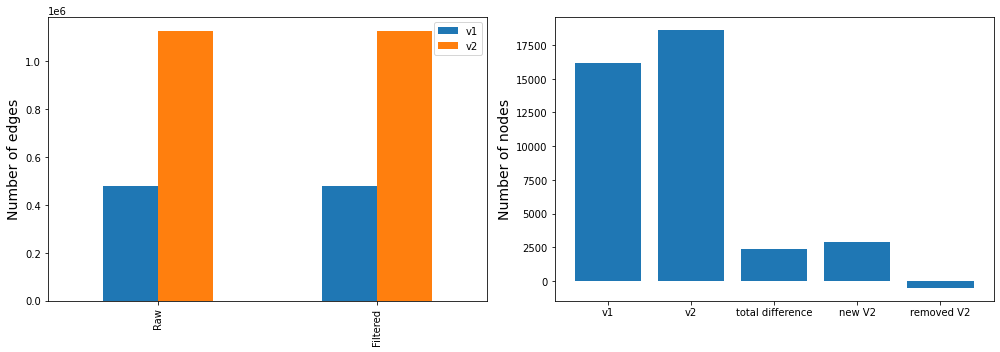

In [44]:
fig, axes = summarize_changes("HumanNet", "","_XC")

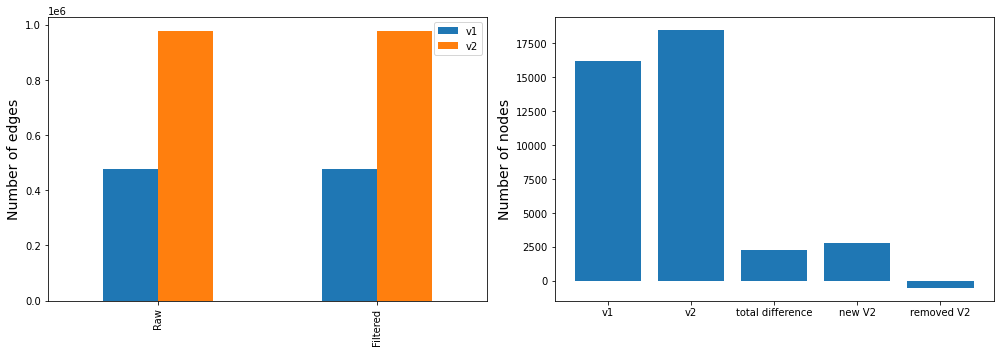

In [45]:
fig, axes = summarize_changes("HumanNet", "","_FN")

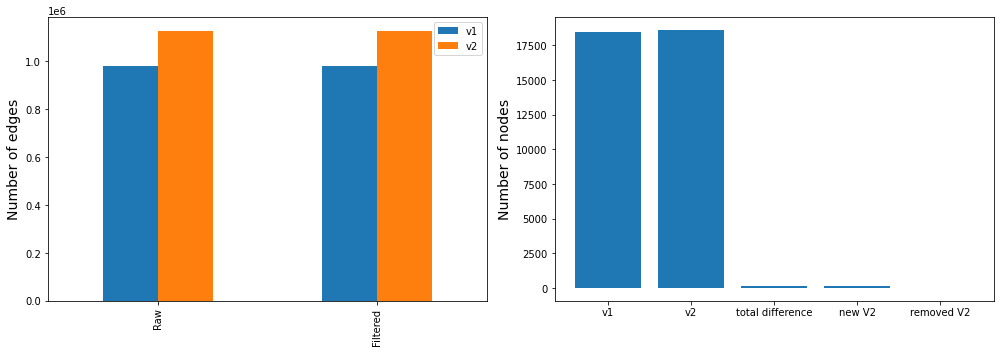

In [48]:
# The XC network contains ~ 10% more edges, and a few new nodes
fig, axes = summarize_changes("HumanNet", "_FN","_XC")